# Comparison: GD vs Maxvol approach for approximation (1-D case)
We need to compare approaches in the following sences:
* **Condition number** or/and **determinant** of the resulting matrix $A$ 

* Derive analytical dependence of $\det(A^{+}A)$ from $x$ – sampling interval, and use it in GD 
* ...
* Profit!

In [1]:
import numpy as np
import numpy.linalg as LA
from numpy.polynomial import Chebyshev as T
from scipy import optimize
from maxvolpy.maxvol import maxvol
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# generate polynomial matrix 
def gen_mat(points, degree):
    num_of_columns = degree + 1
    A = np.zeros((len(points), num_of_columns), dtype = np.float64)
    for i in range(num_of_columns):
        #A[:, i] = points[:]**i #uncomment for the monomial case
        A[:, i] = T.basis(i)(points[:]) #uncomment for Chebyshev polynomials
    return A

In [3]:
# calculation of condition number
# LOSS FUNCTION 
def cond_handmade(points):
    matrix = gen_mat(points, degree)
    return ((LA.norm(matrix, 2) * LA.norm(LA.pinv(matrix), 2)) / LA.norm(matrix, 1)**2)

In [384]:
# plotting and errors of approximation

def plot_and_err(x_gd, x_new_gd, x_maxvol, interval):
    
    # solution to the linear system
    c_gd = LA.solve(gen_mat(x_gd, degree), f(x_gd))
    c_maxvol = LA.solve(gen_mat(x_maxvol, degree), f(x_maxvol))
    c_new_gd = LA.solve(gen_mat(x_new_gd, degree), f(x_new_gd))
    
    rhs = f(interval)
    rhs_gd = np.polynomial.chebyshev.chebval(interval, c_gd)
    rhs_new_gd = np.polynomial.chebyshev.chebval(interval, c_new_gd)
    rhs_maxvol = np.polynomial.chebyshev.chebval(interval, c_maxvol)
    
    # error estimation
    err_maxvol = round((LA.norm(rhs - rhs_maxvol, 2) / LA.norm(rhs, 2)), 4)
    err_gd = round((LA.norm(rhs - rhs_gd, 2) / LA.norm(rhs, 2)), 4)
    err_new_gd = round((LA.norm(rhs - rhs_new_gd, 2) / LA.norm(rhs, 2)), 4)
    
    # plotting
    __ , axarr = plt.subplots(1, 4, figsize=(18, 5))
    
    axarr[0].grid(True)
    axarr[0].plot(interval, rhs, 'b', interval, rhs_maxvol, 'r--', x_maxvol, f(x_maxvol), 'go')
    axarr[0].set_title('Maxvol error = ' + str(err_maxvol))
    axarr[0].set_xlabel("X")
    axarr[0].set_ylabel("f(X)")
    
    axarr[1].grid(True)
    axarr[1].plot(interval, rhs, 'b', interval, rhs_gd, 'r--', x_gd, f(x_gd), 'go')
    axarr[1].set_title('GD error = ' + str(err_gd))
    axarr[1].set_xlabel("X")
    axarr[1].set_ylabel("f(X)")
    
    axarr[2].grid(True)
    axarr[2].plot(interval, rhs, 'b', interval, rhs_new_gd, 'r--', x_new_gd, f(x_new_gd), 'go')
    axarr[2].set_title('NEW GD error = ' + str(err_new_gd))
    axarr[2].set_xlabel("X")
    axarr[2].set_ylabel("f(X)")
    
    axarr[3].grid(True)
    axarr[3].plot(range(len(x_0)), np.sort(res[0]), 'g^', range(len(x_0)), np.sort(mat[row_indx, 1]), 'ro', label = ["asdas","d"])
    axarr[3].set_title('GD vs Maxvol')
    axarr[3].set_xlabel("N – point number")
    axarr[3].set_ylabel("X")
    
    plt.show()

# approximated function
def f(x):
    return np.exp(x)*np.sin(x)#(x**8 - x**5 + x**3 - 1)

#### Workspace 

In [385]:
degree = 3
left = 1
right = 4
num_points = degree + 1

x_0 = np.linspace(left, right, num_points) 
x_big = np.linspace(left, right, 1000000) 

bnds = tuple((left, right) for i in x_0)

#### Gradient Descent

In [386]:
res = optimize.fmin_l_bfgs_b(cond_handmade, x_0, approx_grad = 1, factr = 10.0, bounds = bnds)
print(np.sort(res[0]), '\n Cond_num = ', res[1])

[ 1.          1.82090474  3.51450529  4.        ] 
 Cond_num =  0.0251001199327


#### Maxvol

In [387]:
mat = gen_mat(x_big, degree)
row_indx, _ = maxvol(mat, tol = 1, max_iters = 1000000)
print(np.sort(mat[row_indx, 1]), '\n Cond_num = ', LA.cond(mat[row_indx]))

[ 1.          1.82917983  3.17082017  4.        ] 
 Cond_num =  4217.61238714


In [388]:
#plot_and_err(np.sort(res[0]), np.sort(mat[row_indx, 1]), x_big)

In [389]:
LA.cond(gen_mat(np.sort(res[0]), degree))

4571.8754800623092

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------# 

In [390]:
def grad_det(points):
    A = gen_mat(points, degree)
    grad = np.zeros(len(points))
    B_inv = LA.inv(np.dot(A.conj().T, A))
    for k in range(len(grad)):
        for i in range(B_inv.shape[0]):
            for j in range(B_inv.shape[0]):            
                grad[k] += B_inv[j,i] * (T.deriv(T.basis(i))(points[k])*T.basis(j)(points[k]) +
                                         T.basis(i)(points[k])*T.deriv(T.basis(j))(points[k]))
    return -grad 
#------------------------------------------------------------------------------------------------
def loss_det(points):
    A = gen_mat(points, degree)
    S = LA.svd(A, compute_uv = False)
    #det = LA.det(np.dot(A.conj().T, A))
    det = np.prod(S)**2
    #print(np.dot(A.conj().T, A))
    #print("det = ", det, "\n")
    #print(points)
    #if (det < 0):
    #    print("AAAA!!! = ", det)
    #    det = 1e-10
    return np.log(det)

In [391]:
#degree = 3
#x_0 = np.array([7,7.00001,8,9])#np.linspace(7, 9, 4) 
print(x_0)

[ 1.  2.  3.  4.]


In [392]:
grad_det(x_0)

array([ 3.66666667,  1.        , -1.        , -3.66666667])

In [393]:
optimize.minimize(lambda x: -loss_det(x), x_0, jac = grad_det, bounds = bnds)

      fun: -9.2950409852065814
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.00000000e+00,  -1.56020974e-10,   1.57001523e-10,
        -4.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 4
   status: 0
  success: True
        x: array([ 1.        ,  1.82917961,  3.17082039,  4.        ])

In [394]:
opt = optimize.fmin_l_bfgs_b(lambda x: -loss_det(x), x_0, fprime = grad_det, factr = 10.0, bounds = bnds)
#print(np.sort(res[0]), '\n Cond_num = ', res[1])
opt

(array([ 1.        ,  1.82917961,  3.17082039,  4.        ]),
 -9.2950409852065814,
 {'funcalls': 6,
  'grad': array([  4.00000000e+00,  -1.56020974e-10,   1.57001523e-10,
          -4.00000000e+00]),
  'nit': 4,
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [395]:
optimize.check_grad(loss_det, grad_det, x_0)

10.749660301815572

In [396]:
optimize.approx_fprime(x_0, loss_det, epsilon = 1e-10)

array([-3.66785713, -1.00097708,  0.99868558,  3.66647157])

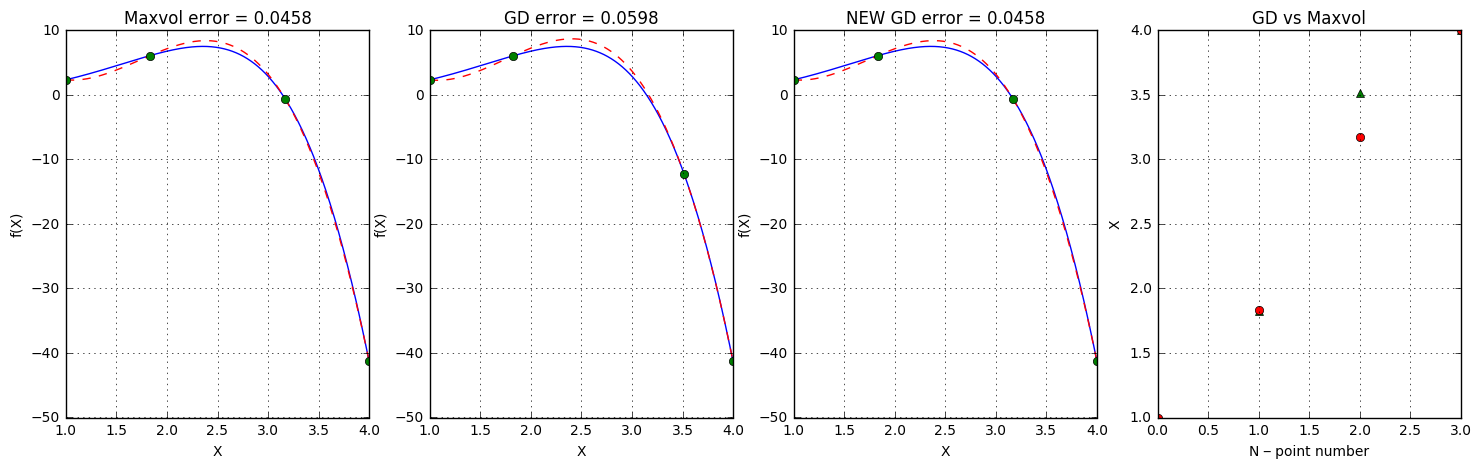

In [397]:
plot_and_err(np.sort(res[0]), np.sort(opt[0]), np.sort(mat[row_indx, 1]), x_big)